# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**.
* **NOTE:** The **watchlist** module is independent of Pandas TA. To easily use it, copy it from your local pandas_ta installation directory into your project directory.

### Required Packages
##### Uncomment the packages you need to install or are missing

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install mplfinance
#!pip install pandas-datareader
#!pip install requests_cache
#!pip install alphaVantage-api # Required for Watchlist

In [2]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

import numpy as np
import pandas as pd
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 20)

import mplfinance as mpf
import pandas_ta as ta

from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib
Numpy v1.20.1
Pandas v1.2.2
mplfinance v0.12.7a5

Pandas TA v0.2.45b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



## MISC Functions

In [3]:
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

## Collect some Data

In [4]:
tf = "D"
tickers = ["SPY", "QQQ", "AAPL", "TSLA", "BTC-USD"]
watch = Watchlist(tickers, tf=tf, ds_name="yahoo", timed=True)
watch.strategy = ta.CommonStrategy
watch.load(tickers, analyze=True, verbose=False)

[!] Loading All: SPY, QQQ, AAPL, TSLA, BTC-USD
[+] Downloading[yahoo]: SPY[D]
[+] Saving: /Users/kj/av_data/SPY_D.csv
[i] Runtime: 502.4630 ms (0.5025 s)
[+] Downloading[yahoo]: QQQ[D]
[+] Saving: /Users/kj/av_data/QQQ_D.csv
[i] Runtime: 489.0737 ms (0.4891 s)
[+] Downloading[yahoo]: AAPL[D]
[+] Saving: /Users/kj/av_data/AAPL_D.csv
[i] Runtime: 473.5644 ms (0.4736 s)
[+] Downloading[yahoo]: TSLA[D]
[+] Saving: /Users/kj/av_data/TSLA_D.csv
[i] Runtime: 499.7529 ms (0.4998 s)
[+] Downloading[yahoo]: BTC-USD[D]
[+] Saving: /Users/kj/av_data/BTC-USD_D.csv
[i] Runtime: 519.3540 ms (0.5194 s)


# Select an Asset

In [5]:
ticker = tickers[0]
print(f"{ticker} {watch.data[ticker].shape}\nColumns: {', '.join(list(watch.data[ticker].columns))}")

SPY (7067, 12)
Columns: open, high, low, close, volume, Dividends, Stock Splits, SMA_10, SMA_20, SMA_50, SMA_200, VOL_SMA_20


### Trim it

In [6]:
duration = "1y"
recent = recent_bars(watch.data[ticker], duration)
asset = watch.data[ticker].copy().tail(recent)

# Create a Trend

In [7]:
# Example Long Trends
# long = ta.sma(asset.close, 10) < ta.sma(asset.close, 20) # SMA(10) > SMA(20)
long = ta.ema(asset.close, 8) > ta.ema(asset.close, 21) # EMA(8) > EMA(21)
# long = ta.increasing(ta.ema(asset.close, 50))
# long = ta.macd(asset.close).iloc[:,1] > 0 # MACD Histogram is positive

asset.ta.ema(length=8, append=True)
asset.ta.ema(length=21, append=True)
asset.ta.ema(length=50, append=True)
asset[asset.columns[5:]].tail()

,Dividends,Stock Splits,SMA_10,SMA_20,SMA_50,SMA_200,VOL_SMA_20,EMA_8,EMA_21,EMA_50
date,,,,,,,,,,
2021-02-16,0.0,0,388.378998,383.998502,376.217993,338.123101,61830575.00,389.396569,384.415811,375.943397
2021-02-17,0.0,0,389.463000,384.685503,376.763122,338.688860,61883440.00,390.061779,385.140739,376.588362
2021-02-18,0.0,0,390.350000,385.027002,377.211919,339.242418,61769245.00,390.208050,385.647945,377.142544
2021-02-19,0.0,0,390.734000,385.316502,377.662051,339.779591,63528595.00,390.168483,386.046313,377.647934
2021-02-22,0.0,0,390.851001,385.616502,378.067675,340.320591,62470673.85,389.882155,386.303921,378.088408


## Calculate Trend Returns from the long trend

In [8]:
trendy = asset.ta.trend_return(trend=long, cumulative=True, trade_offset=-1, append=True)
trendy.tail() # Third Column is the long trend; binary sequences

,CLTR,TR_LOGRET,CLTR_Trends,CLTR_Trades
date,,,,
2021-02-16,0.136977,-0.000866,1,0
2021-02-17,0.137206,0.000229,1,0
2021-02-18,0.132941,-0.004265,1,0
2021-02-19,0.131174,-0.001768,1,0
2021-02-22,0.128221,-0.002953,1,0


### Simple Price Chart

<AxesSubplot:title={'center':'SPY Monday February 22, 2021, NYSE: 6:21:58, Local: 10:21:58 PST, Day 53/365 (15.0%)'}, xlabel='date'>

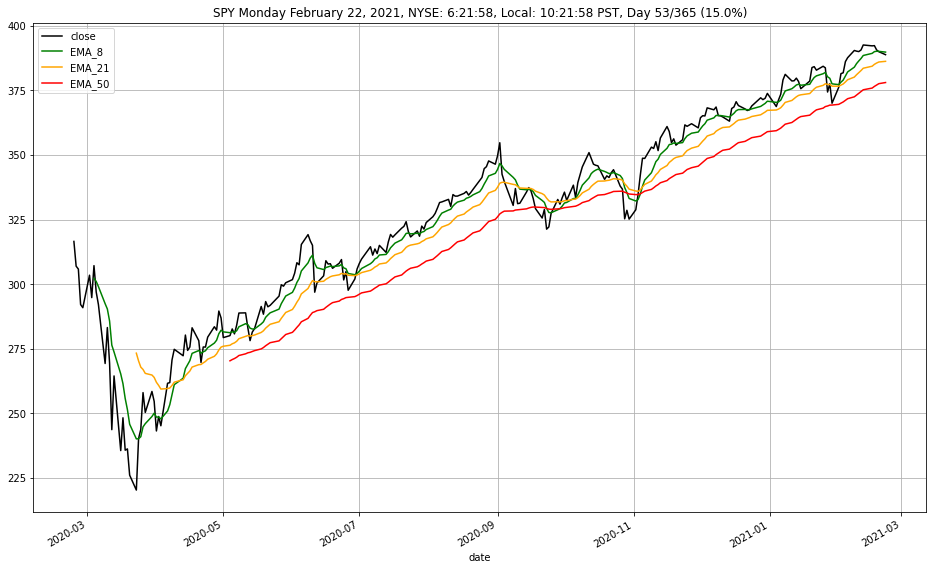

In [9]:
extime = ta.get_time(to_string=True)
chart_ = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart_.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=f"{ticker} {extime}", grid=True)

## Entries & Exits

In [10]:
entries = (trendy.iloc[:,-1] > 0).astype(int) * asset.close
entries[entries < 0.0001] = np.nan
entries.name = "Entry"


exits = (trendy.iloc[:,-1] < 0).astype(int) * asset.close
exits[exits < 0.0001] = np.nan
exits.name = "Exit"

total_trades = trendy.iloc[:,-1].abs().sum()
print(f"Total Trades: {total_trades}")

all_trades = trendy.iloc[:,-1].copy().fillna(0)
all_trades = all_trades[all_trades != 0]

trades = pd.DataFrame({"Signal": all_trades, entries.name: entries.dropna(), exits.name: exits.dropna()})
trades

Total Trades: 5


,Signal,Entry,Exit
date,,,
2020-04-09,1,274.705811,NaN
2020-09-10,-1,NaN,331.147217
2020-10-02,1,332.423004,NaN
2020-10-27,-1,NaN,336.784393
2020-11-04,1,342.081818,NaN


## Chart Display Strings

In [11]:
first_date, last_date = asset.index[0], asset.index[-1]
f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
last_ohlcv = f"Last OHLCV: ({asset.iloc[-1].open:.4f}, {asset.iloc[-1].high:.4f}, {asset.iloc[-1].low:.4f}, {asset.iloc[-1].close:.4f}, {int(asset.iloc[-1].volume)})"
ptitle = f"\n{ticker} [{tf} for {duration}({recent} bars)] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"

## Trade Chart

<AxesSubplot:title={'center':'\nSPY [D for 1y(252 bars)] from Monday 2-24-2020 to Monday 2-22-2021\nLast OHLCV: (387.0600, 388.9000, 386.7400, 388.8800, 31702077)\nMonday February 22, 2021, NYSE: 6:21:58, Local: 10:21:58 PST, Day 53/365 (15.0%)'}, xlabel='date'>

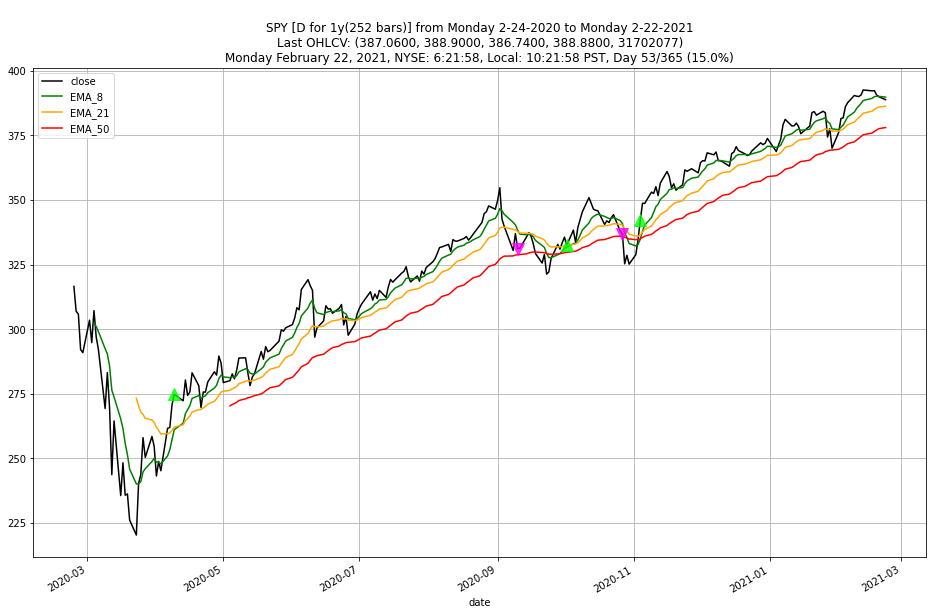

In [12]:
# chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# chart = asset[["close", "SMA_10", "SMA_20"]]
chart = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=ptitle, grid=True)
entries.plot(figsize=(16, 10), color=colors("FcLi")[1], marker="^", markersize=12, alpha=0.8)
exits.plot(figsize=(16, 10), color=colors("FcLi")[0], marker="v", markersize=12, alpha=0.8, grid=True)

## Trend Returns and Cumulative Trend Returns

<AxesSubplot:xlabel='date'>

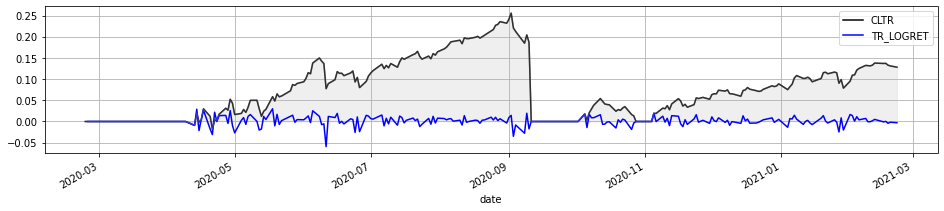

In [13]:
cltr = trendy.iloc[:,0]
tr = trendy.iloc[:,1]

trendy.iloc[:,:2].plot(figsize=(16, 3), color=colors("BkBl"))
cltr.plot(figsize=(16, 3), kind="area", stacked=False, color=colors("SvGy")[0], alpha=0.25, grid=True)

# Total Return

<AxesSubplot:xlabel='date'>

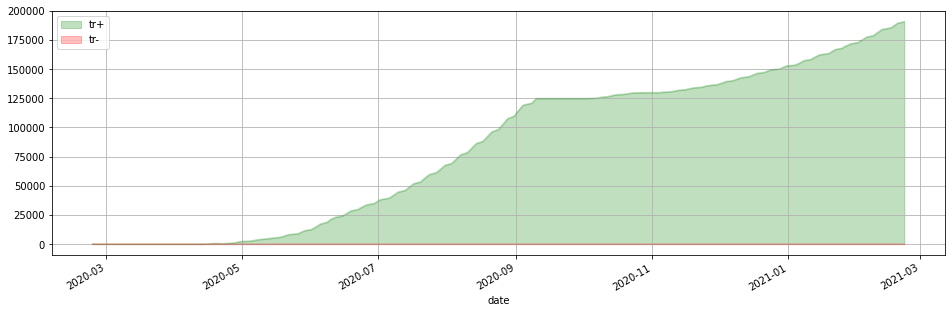

In [14]:
capital = 10000

total_return = cltr.cumsum() * capital
positive_return = total_return[total_return > 0]
negative_return = total_return[total_return <= 0]
trdf = pd.DataFrame({"tr+": positive_return, "tr-": negative_return})
trdf.plot(figsize=(16, 5), color=colors(), kind="area", stacked=False, alpha=0.25, grid=True)

## Long and Short Trends

<AxesSubplot:xlabel='date'>

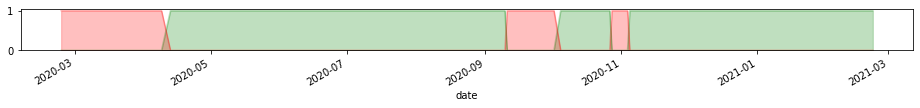

In [15]:
long_trend = (trendy.iloc[:,-2] > 0).astype(int)
short_trend = (1 - long_trend).astype(int)

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25)
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25)

# AI Analysis

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.